In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
np.random.seed(30)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from collections import Counter
import keras
from keras.layers import Conv2D,Dense,Flatten
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from sklearn.model_selection import KFold


/home/rithwik/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
days = pd.HDFStore('../Combined Datasets/daily.h5','r')
hours = pd.HDFStore('../Combined Datasets/hourly.h5','r')

In [3]:
train_prop = .65
v_prop = .2
test_prop = .15
keys = days.keys()

const = 1000.0

In [4]:
def return_data(keys,n_months):
    

    appliance1 = 'use'
    appliance2 = 'air1'
    
    

    
    X = np.array([days[i][appliance1].values for i in keys if (appliance1 in days[i].columns and appliance2 in days[i].columns )])[:,:28*n_months]/const
    y = np.array([hours[i][appliance2].values for i in keys if (appliance1 in hours[i].columns and appliance2 in hours[i].columns )])[:,:(28*24*n_months)]/const
    
    X = X.reshape((len(X)*n_months,4,7))
    X = np.expand_dims(X,axis=3)    
    
    
    
    y = y.reshape((len(y)*n_months,28*24))
    
    
    
    return X,y


def mae(truth,pred):
    return np.mean(const*np.abs((truth-pred)))

    
    
    

In [5]:
def network():
    
    input_layer = Input(shape=(4,7,1),name="Monthly_Matrix")
    input_layer_2 = Input(shape=(1,),name="Cooling_Degree_Day_Monthly")
    

    op1 = Conv2D(10,kernel_size=(4,1), strides=(1,1),name="Filter_4X1")(input_layer)
    
    op1 = Flatten()(op1)
    
    
    
    op2 = Conv2D(10,kernel_size=(1,7), strides=(1,1),name="Filter_1X7")(input_layer)
    
    op2 = Flatten()(op2)
    
    
    op3 = Conv2D(10,kernel_size=(1,2),strides=(1,1),name="Filter_1X2")(input_layer)
    
    op3 = Flatten()(op3)
    
    op4 = Conv2D(10,kernel_size=(2,1),strides=(1,1),name="Filter_2X1")(input_layer)
    
    op4 = Flatten()(op4)
    
    #op5 = Conv2D(20,kernel_size=(3,3),strides=(1,1),padding='same')(input_layer)
    
    #op5 = Conv2D(20,3,strides=(1,1),padding='same')(input_layer)
    
    #op5 = Flatten()(op5)
    
    #op5 =  keras.layers.Dropout(.2)(op5)
    
    #op5  = Dense(168*4)(op5)
    
    
    
    
    
    
    
    
    
    merge_layer = keras.layers.concatenate([op1, op2, op3,op4],name="Concatenation_1")
    

    
    merge_layer =  keras.layers.Dropout(.2)(merge_layer)
    
    
    
    merge_layer = keras.layers.concatenate(([merge_layer,input_layer_2]),name="Concatenation_2")
    
    final_layer = Dense(168*4,name="Output_Dense",activation='relu')(merge_layer)
    
    
    #final_layer = keras.layers.LeakyReLU(alpha=0.01)(final_layer)
    
    #predictions = Dense(1, activation='sigmoid')(merge_layer)

    
    
    
    model = Model(inputs=[input_layer,input_layer_2], outputs=final_layer)

    
    return model
    
    

In [6]:
def empty_dir(dir_name):
    for i in os.listdir(dir_name):
        os.remove(dir_name+"/"+i)

In [14]:
def fit_model(train_x,train_y,test_x,test_y,v_x,v_y):
    
    model = network()
    n_epochs = 1000
    sgd = keras.optimizers.SGD(lr=0.03)
    rmsprop  = keras.optimizers.RMSprop(lr=.001)
    adagrad = keras.optimizers.adagrad(lr=.001)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    
    dir_name = 'temp'
    empty_dir(dir_name)
    
    print("Started Training!")
    checkpoint = ModelCheckpoint(dir_name+'/single-model-{epoch:04d}.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
    model.fit([train_x,train_temp], train_y, epochs=n_epochs, validation_data=[[v_x,v_temp],v_y], callbacks=[checkpoint], verbose=0)

    all_files = os.listdir(dir_name)
    all_files.sort()
    weights_file = all_files[-1]
    
    
    model.load_weights(dir_name+"/"+weights_file)
    
    
    pred_train = model.predict([train_x,train_temp])
    pred_v = model.predict([v_x,v_temp])
    pred_test = model.predict([test_x,test_temp])
    
    train_cost = mae(train_y,pred_train)
    v_cost = mae(v_y,pred_v)
    test_cost = mae(test_y,pred_test)
    
    return train_cost,v_cost,test_cost
    
    
    
    
    
    
    

In [15]:
n_experiments = 5
results_arr = [] 
for exp in range(n_experiments):
    
    keys = days.keys()

    np.random.seed(exp)
    
    np.random.shuffle(keys)

    train_homes = keys[:int(len(keys)*train_prop)]
    test_homes = keys[int(len(keys)*train_prop):int(-len(keys)*v_prop)]
    val_homes = keys[int(-len(keys)*v_prop):]
    
    train_x,train_y = return_data(train_homes,3)
    
    test_x,test_y = return_data(test_homes,3)
    
    v_x,v_y  = return_data(val_homes,3)
    
    
    
    vals = [16,18,21]
    
    
    train_temp = np.array(vals*(len(train_x)/3))
    
    v_temp = np.array(vals*(len(v_x)/3))
    
    test_temp = np.array(vals*(len(test_x)/3))
    
    
    
    
    results = fit_model(train_x,train_y,test_x,test_y,v_x,v_y)
    
    print (results)
    
    results_arr.append(results)
    

Started Training!
(219.74353, 201.95308, 197.64436)
Started Training!
(198.95792, 210.8549, 274.86588)
Started Training!
(206.91428, 217.63936, 225.63892)
Started Training!
(218.28247, 203.0724, 198.06882)
Started Training!
(190.25533, 168.88123, 334.48624)


In [16]:
results_arr = np.array(results_arr)

In [17]:
np.mean(results_arr,axis=0)

array([206.83072, 200.4802 , 246.14084], dtype=float32)

In [22]:
v_x.sum()

28471.994

In [23]:
v_y.sum()

6779.1816

In [9]:
model = network()
model.load_weights("temp/single-model-2969.h5")

In [10]:
for i in model.get_weights():
    print (i.shape)

(4, 1, 1, 10)
(10,)
(1, 7, 1, 10)
(10,)
(1, 2, 1, 10)
(10,)
(2, 1, 1, 10)
(10,)
(561, 672)
(672,)


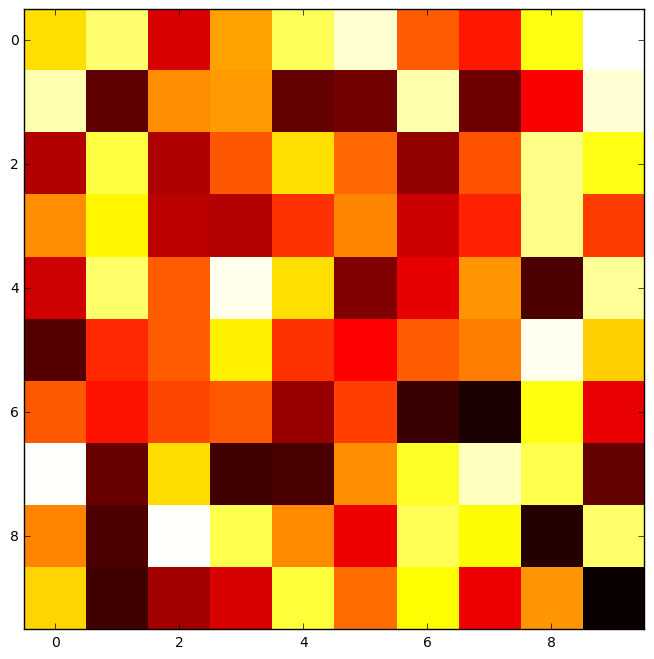

In [12]:
curr_weights = model.get_weights()[-2][-10:,:10]
plt.figure(figsize=(20,8))
plt.imshow(curr_weights, cmap='hot',interpolation="nearest")
plt.show()

In [13]:
curr_weights

array([[ 0.02596976,  0.0482963 , -0.02839687,  0.01316852,  0.04524082,
         0.06178158, -0.00160338, -0.01570191,  0.03527257,  0.06876647],
       [ 0.05722498, -0.05457132,  0.00863692,  0.01152798, -0.05326628,
        -0.05017353,  0.05693913, -0.05115849, -0.02168653,  0.06246469],
       [-0.03715538,  0.04195913, -0.0373541 , -0.00283418,  0.02592027,
         0.00122386, -0.04379235, -0.00320593,  0.05182707,  0.03609965],
       [ 0.00881093,  0.0307638 , -0.03529026, -0.03643909, -0.01025578,
         0.00697697, -0.03152126, -0.01388553,  0.05213583, -0.00832125],
       [-0.03100645,  0.04740818, -0.00138092,  0.06596863,  0.02590018,
        -0.04719331, -0.02574683,  0.01049333, -0.05825188,  0.05438694],
       [-0.05700709, -0.01183079, -0.00184746,  0.03001938, -0.01021702,
        -0.02104314, -0.00141323,  0.00567264,  0.06613807,  0.0228859 ],
       [-0.00198874, -0.0169977 , -0.00609615, -0.00218449, -0.04219309,
        -0.00743559, -0.06231263, -0.06871634

In [34]:
model.get_weights()[-1].shape

(672,)

In [16]:
model.get_weights()[-2].mean(axis=1)

array([ 1.14541000e-03,  2.74822291e-04,  1.29201310e-03, -1.98219484e-03,
        2.33696331e-03, -7.54793931e-04,  5.49861754e-04, -8.04647803e-03,
       -1.29135570e-03, -3.73425824e-03, -1.15119771e-03,  5.73037716e-04,
       -1.07128530e-04, -9.01163265e-04,  1.95944170e-03, -6.59113284e-04,
        1.67960345e-04, -4.78815660e-03, -2.52046925e-03, -5.03523927e-03,
       -1.58396771e-03, -5.11171005e-04, -4.63839853e-04, -1.92508602e-03,
        1.49328809e-03,  2.66265444e-04, -8.10756057e-04, -4.59716236e-03,
       -9.45417094e-04, -6.42996328e-03, -8.86817346e-04,  5.05485979e-04,
       -1.33865711e-03, -3.38044553e-03,  1.10516092e-03, -1.33833720e-03,
       -2.70576449e-04, -4.35252488e-03, -5.07714367e-03, -4.99378936e-03,
       -2.02748436e-03,  1.05852319e-03, -2.95965420e-03, -3.96772241e-03,
       -1.85232959e-03,  1.64236291e-03,  7.77982874e-04, -2.90715345e-03,
        1.40838150e-04, -3.78846517e-03, -1.98350474e-03,  7.53938628e-04,
       -1.17259077e-03, -